In [3]:
import time
from datasets import load_dataset

# Try importing Ollama SDK
try:
    from ollama import chat
    OLLAMA_AVAILABLE = True
except ImportError:
    OLLAMA_AVAILABLE = False
    print("Ollama SDK not installed. Install via: pip install ollama")

# -----------------------------
# Load dataset (100 samples)
# -----------------------------
dataset = load_dataset("imdb", split="test").select(range(100))
queries = dataset['text']

# -----------------------------
# Measure ONLY Ollama runtime
# -----------------------------
def measure_ollama_runtime(queries):
    if not OLLAMA_AVAILABLE:
        print("Ollama not available, skipping timing.")
        return

    print("Measuring Ollama LLM runtime...")

    start = time.time()

    for i, q in enumerate(queries, 1):
        prompt = f"Say 'OK' for this input:\n\"{q}\""
        try:
            chat(model="qwen2.5:7b", messages=[{"role": "user", "content": prompt}])
        except Exception as e:
            print(f"Ollama error on query {i}: {e}")
            break

    total_time = round(time.time() - start, 2)
    print(f"\nTotal Ollama Runtime for {len(queries)} queries: {total_time} seconds")
    print(f"Average per query: {round(total_time/len(queries), 2)} seconds/query")


# -----------------------------
# MAIN
# -----------------------------
if __name__ == "__main__":
    measure_ollama_runtime(queries)


Measuring Ollama LLM runtime...

 Total Ollama Runtime for 100 queries: 215.71 seconds
Average per query: 2.16 seconds/query


Using Apple Silicon GPU (MPS)

Final Model Results:
{'model': 'distilbert-base-uncased-finetuned-sst-2-english', 'accuracy': 89.0, 'latency': 2.67}
{'model': 'finiteautomata/bertweet-base-sentiment-analysis', 'accuracy': 59.0, 'latency': 2.61}
{'model': 'textattack/bert-base-uncased-SST-2', 'accuracy': 84.0, 'latency': 4.64}
{'model': 'roberta-large-mnli', 'accuracy': 10.0, 'latency': 13.49}
{'model': 'siebert/sentiment-roberta-large-english', 'accuracy': 95.0, 'latency': 13.56}

Plotting Accuracy vs Latency...


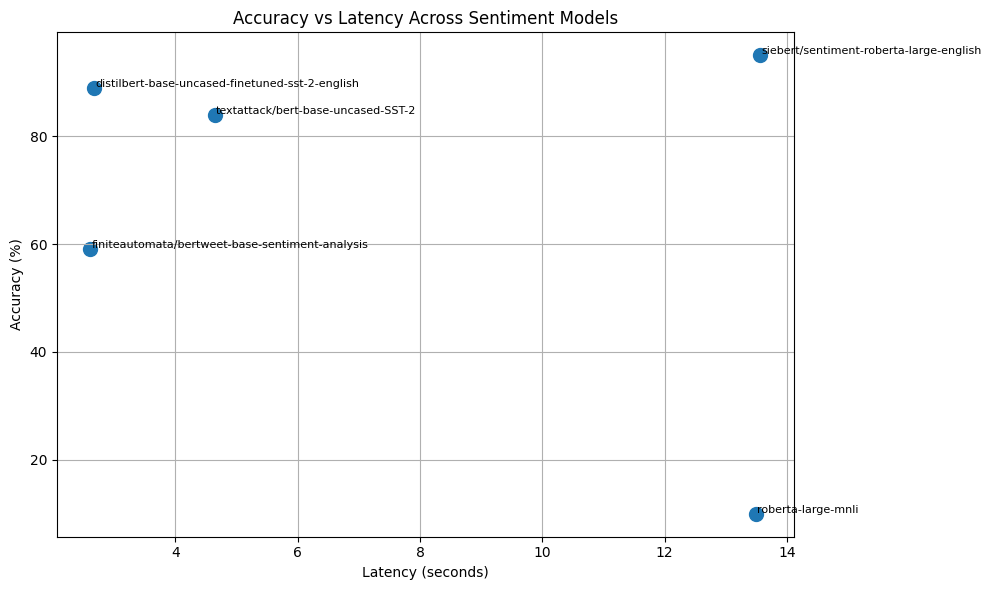

In [4]:
import warnings
import logging
import time
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Suppress warnings/logs
logging.getLogger("transformers").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

# -----------------------------
# Sentiment models
# -----------------------------
SENTIMENT_MODELS = [
    "distilbert-base-uncased-finetuned-sst-2-english",
    "finiteautomata/bertweet-base-sentiment-analysis",
    "textattack/bert-base-uncased-SST-2",
    "roberta-large-mnli",
    "siebert/sentiment-roberta-large-english"
]

# -----------------------------
# Detect device
# -----------------------------
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
else:
    DEVICE = torch.device("cpu")
    print("MPS not available — using CPU")

# -----------------------------
# Load dataset (100 samples)
# -----------------------------
dataset = load_dataset("imdb", split="test").select(range(100))
queries = dataset['text']
true_labels = dataset['label']

# -----------------------------
# Run model on MPS/CPU
# -----------------------------
def run_model_mps(model_name, queries):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.to(DEVICE)
    model.eval()

    predictions = []

    for q in queries:
        encoded = tokenizer(q, return_tensors="pt", truncation=True, padding=True).to(DEVICE)
        with torch.no_grad():
            output = model(**encoded)
            pred_label = output.logits.argmax(dim=1).item()
        predictions.append(pred_label)

    return predictions

# -----------------------------
# Run all models and compute accuracy + latency
# -----------------------------
def run_all_models(queries, true_labels):
    results = []

    for model_name in SENTIMENT_MODELS:
        try:
            start = time.time()
            preds = run_model_mps(model_name, queries)
            acc = round(accuracy_score(true_labels, preds) * 100, 2)
            latency = round(time.time() - start, 2)

            results.append({
                "model": model_name,
                "accuracy": acc,
                "latency": latency
            })

        except Exception as e:
            print(f"Model failed: {model_name}, Error: {e}")

    return results

# -----------------------------
# Plot Accuracy–Latency Graph
# -----------------------------
def plot_accuracy_latency(results):
    accuracies = [r["accuracy"] for r in results]
    latencies = [r["latency"] for r in results]
    labels = [r["model"] for r in results]

    plt.figure(figsize=(10, 6))
    plt.scatter(latencies, accuracies, s=100)

    # Add labels next to points
    for i, label in enumerate(labels):
        plt.annotate(label, (latencies[i] + 0.02, accuracies[i] + 0.2), fontsize=8)

    plt.xlabel("Latency (seconds)")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy vs Latency Across Sentiment Models")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    results = run_all_models(queries, true_labels)

    print("\nFinal Model Results:")
    for r in results:
        print(r)

    print("\nPlotting Accuracy vs Latency...")
    plot_accuracy_latency(results)


In [5]:
import warnings
import logging
import time
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import accuracy_score

# Try loading Ollama SDK
try:
    from ollama import chat
    OLLAMA_AVAILABLE = True
except ImportError:
    OLLAMA_AVAILABLE = False
    print("Ollama SDK not installed. Ollama recommendations will be skipped.")

# Suppress warnings/logs
logging.getLogger("transformers").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

# -----------------------------
# Sentiment models
# -----------------------------
SENTIMENT_MODELS = [
    "distilbert-base-uncased-finetuned-sst-2-english",
    "finiteautomata/bertweet-base-sentiment-analysis",
    "textattack/bert-base-uncased-SST-2",
    "roberta-large-mnli",
    "siebert/sentiment-roberta-large-english"
]

# -----------------------------
# Label map
# -----------------------------
LABEL_MAP = {
    "LABEL_0": 0, "LABEL_1": 1,
    "1 star": 0, "2 stars": 0, "3 stars": 0,
    "4 stars": 1, "5 stars": 1
}

# -----------------------------
# Detect device
# -----------------------------
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
else:
    DEVICE = torch.device("cpu")
    print("MPS not available — using CPU")

# -----------------------------
# Load dataset
# -----------------------------
dataset = load_dataset("imdb", split="test").select(range(100))  # smaller sample
queries = dataset['text']
true_labels = dataset['label']

# -----------------------------
# MPS-safe model inference
# -----------------------------
def run_model_mps(model_name, queries):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.to(DEVICE)
    model.eval()

    predictions = []
    for q in queries:
        encoded = tokenizer(q, return_tensors="pt", truncation=True, padding=True).to(DEVICE)
        with torch.no_grad():
            output = model(**encoded)
            pred_label = output.logits.argmax(dim=1).item()
        predictions.append(pred_label)

    return predictions

# -----------------------------
# Run all models and measure accuracy/latency with early stopping
# -----------------------------
def run_batch_sentiment_analysis(queries, true_labels, query_type="accuracy", target_acc=0):
    results = []
    best_acc = 0
    best_latency = float('inf')

    for model_name in SENTIMENT_MODELS:
        try:
            start = time.time()
            preds = run_model_mps(model_name, queries)
            acc = round(accuracy_score(true_labels, preds) * 100, 2)
            latency = round(time.time() - start, 2)

            # -----------------------------
            # Early stopping logic
            # -----------------------------
            skip_model = False

            if query_type == "accuracy":
                # Skip if accuracy worse than current best or same accuracy but slower
                if acc < best_acc or (acc == best_acc and latency > best_latency):
                    skip_model = True
            elif query_type == "latency":
                # Skip if below target accuracy
                if acc < target_acc:
                    skip_model = True
                # Also skip if same accuracy but slower than previous best
                elif acc == best_acc and latency > best_latency:
                    skip_model = True

            if skip_model:
                #print(f"Skipping {model_name} — worse than current best")
                continue

            # Keep this model
            results.append({"model": model_name, "accuracy": acc, "latency": latency})
            #print(f"{model_name} -> Accuracy: {acc}%, Latency: {latency}s")

            # Update best metrics
            if acc > best_acc:
                best_acc = acc
                best_latency = latency
            elif acc == best_acc:
                best_latency = min(best_latency, latency)

        except Exception as e:
            print(f"Model failed: {model_name}, Error: {e}")

    return results

# -----------------------------
# Ollama selection
# -----------------------------
def ollama_select_model(results, query_type="accuracy", target_acc=0):
    if not OLLAMA_AVAILABLE or not results:
        return None

    prompt = "You are a model selection assistant.\n"
    prompt += "Here are model results:\n"
    for r in results:
        prompt += f"{r['model']}: accuracy={r['accuracy']} latency={r['latency']}\n"

    if query_type == "accuracy":
        prompt += "\nSelect the best model based on highest accuracy. Break ties using lowest latency. Reply with ONLY the model name."
    elif query_type == "latency":
        prompt += f"\nSelect the fastest model that has accuracy >= {target_acc}%. If multiple, pick the one with the lowest latency. Reply with ONLY the model name."

    try:
        response = chat(model="qwen2.5:7b", messages=[{"role": "user", "content": prompt}])
        return response.message.content.strip()
    except Exception as e:
        print("Ollama error:", e)
        return None

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    # User query
    print("\nQuery options:")
    print("1 - Most accurate model")
    print("2 - Fastest model at target accuracy")
    query_input = input("Enter your query (1 or 2): ").strip()

    if query_input == "1":
        query_type = "accuracy"
        target_acc = 0
    elif query_input == "2":
        query_type = "latency"
        try:
            target_acc = float(input("Enter target accuracy (e.g., 70 for 70%): "))
        except:
            target_acc = 0
    else:
        query_type = "accuracy"
        target_acc = 0

    # Run models
    results = run_batch_sentiment_analysis(queries, true_labels, query_type, target_acc)

    # Ollama selection (use filtered results)
    selected_model = ollama_select_model(results, query_type, target_acc)
    if selected_model:
        print("\nOllama Selected Model:", selected_model)
    else:
        print("\nOllama selection failed. You may fallback to Python selection.")


Using Apple Silicon GPU (MPS)

Query options:
1 - Most accurate model
2 - Fastest model at target accuracy

Ollama Selected Model: siebert/sentiment-roberta-large-english


In [10]:
import warnings
import logging
import time
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import accuracy_score
import json

# Try loading Ollama SDK
try:
    from ollama import chat
    OLLAMA_AVAILABLE = True
except ImportError:
    OLLAMA_AVAILABLE = False
    print("Ollama SDK not installed. Qwen-based recommendations will be skipped.")

# Suppress warnings/logs
logging.getLogger("transformers").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

# -----------------------------
# Sentiment models
# -----------------------------
SENTIMENT_MODELS = [
    "distilbert-base-uncased-finetuned-sst-2-english",
    "finiteautomata/bertweet-base-sentiment-analysis",
    "textattack/bert-base-uncased-SST-2",
    "roberta-large-mnli",
    "siebert/sentiment-roberta-large-english"
]

# -----------------------------
# Detect device
# -----------------------------
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
else:
    DEVICE = torch.device("cpu")
    print("MPS not available — using CPU")

# -----------------------------
# Load dataset (100 samples)
# -----------------------------
dataset = load_dataset("imdb", split="test").select(range(100))
queries = dataset["text"]
true_labels = dataset["label"]

# -----------------------------
# Run a single model
# -----------------------------
def run_model_mps(model_name, queries):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.to(DEVICE)
    model.eval()

    predictions = []

    for q in queries:
        encoded = tokenizer(q, return_tensors="pt", truncation=True, padding=True).to(DEVICE)
        with torch.no_grad():
            output = model(**encoded)
            pred_label = output.logits.argmax(dim=1).item()
        predictions.append(pred_label)

    return predictions

# -----------------------------
# Run all models on 100 queries
# -----------------------------
def run_all_models_100(queries, true_labels):
    results = []

    for model_name in SENTIMENT_MODELS:
        print(f"\nRunning {model_name} on 100 IMDB reviews...")
        try:
            start = time.time()
            preds = run_model_mps(model_name, queries)
            total_latency = time.time() - start  # total time for 100 samples
            acc = round(accuracy_score(true_labels, preds) * 100, 2)

            result = {
                "model": model_name,
                "accuracy_100": acc,
                "latency_100": round(total_latency, 2)  # seconds for all 100
            }
            results.append(result)

            print(f"{model_name} -> Accuracy (100): {acc}%, "
                  f"Total Latency (100): {result['latency_100']}s")

        except Exception as e:
            print(f"Model failed: {model_name}, Error: {e}")

    return results

# -----------------------------
# Qwen (via Ollama) selects best model for 1000 queries
# -----------------------------
def qwen_select_model_for_1000(results_100, query_type="accuracy", target_acc=0):
    if not OLLAMA_AVAILABLE or not results_100:
        print("Qwen not available.")
        return None

    prompt = """
    You are a strict model selection assistant.

    You MUST:
    1. Compute accuracy_1000 = accuracy_100 (same value)
    2. Compute latency_1000 = latency_100 * 10
    3. Choose the best model for 1000 reviews based on the mode.

    Mode:
    - "accuracy": pick model with highest accuracy_1000.
                 If tie → pick lowest latency_1000.
    - "latency": pick lowest latency_1000 among models with accuracy ≥ target_acc.

    IMPORTANT:
    Before choosing, you MUST think step-by-step, comparing values numerically.
    DO NOT skip calculations.

    BUT:
    Your final answer must contain ONLY the model name.
    No explanation.
    No numbers.
    No punctuation.
    No formatting.
    """

    prompt += "\nHere are the results on 100 samples:\n"
    prompt += json.dumps(results_100, indent=2)
    prompt += f"\nMode: {query_type}\n"
    prompt += f"Target accuracy: {target_acc}\n"
    prompt += "\nFinal answer must be ONLY the model name:\n"

    try:
        response = chat(
            model="qwen2.5:7b",
            messages=[{"role": "user", "content": prompt}]
        )
        return response.message.content.strip()
    except Exception as e:
        print("Qwen error:", e)
        return None


# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    print("\nQuery options:")
    print("1 - Most accurate model for 1000 reviews")
    print("2 - Fastest model for 1000 reviews at target accuracy")
    query_input = input("Enter your query (1 or 2): ").strip()

    if query_input == "1":
        query_type = "accuracy"
        target_acc = 0
    elif query_input == "2":
        query_type = "latency"
        try:
            target_acc = float(input("Enter target accuracy (e.g., 90 for 90%): "))
        except Exception:
            target_acc = 0
    else:
        query_type = "accuracy"
        target_acc = 0

    # 1) Run all HF models on 100 IMDB reviews
    results_100 = run_all_models_100(queries, true_labels)

    # 2) Ask Qwen (via Ollama) to scale to 1000 and pick best model
    qwen_output = qwen_select_model_for_1000(results_100, query_type, target_acc)

    if qwen_output:
        print("\nOllama Prediction for 1000 Reviews ===")
        print(qwen_output)
    else:
        print("\nOllama selection failed or Ollama not available.")


Using Apple Silicon GPU (MPS)

Query options:
1 - Most accurate model for 1000 reviews
2 - Fastest model for 1000 reviews at target accuracy

Running distilbert-base-uncased-finetuned-sst-2-english on 100 IMDB reviews...
distilbert-base-uncased-finetuned-sst-2-english -> Accuracy (100): 89.0%, Total Latency (100): 2.4s

Running finiteautomata/bertweet-base-sentiment-analysis on 100 IMDB reviews...
finiteautomata/bertweet-base-sentiment-analysis -> Accuracy (100): 59.0%, Total Latency (100): 2.7s

Running textattack/bert-base-uncased-SST-2 on 100 IMDB reviews...
textattack/bert-base-uncased-SST-2 -> Accuracy (100): 84.0%, Total Latency (100): 4.08s

Running roberta-large-mnli on 100 IMDB reviews...
roberta-large-mnli -> Accuracy (100): 10.0%, Total Latency (100): 11.77s

Running siebert/sentiment-roberta-large-english on 100 IMDB reviews...
siebert/sentiment-roberta-large-english -> Accuracy (100): 95.0%, Total Latency (100): 11.88s

Ollama Prediction for 1000 Reviews ===
siebert/sentim